# The "Blueprint" (Strategic Framework)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df_trades = pd.read_csv('https://drive.google.com/uc?export=download&id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs')
df_trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [12]:
df_sentiment = pd.read_csv('https://drive.google.com/uc?export=download&id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf')
df_sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [10]:
print(df_sentiment.columns)
print(df_trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [13]:
df_trades['clean_date'] = pd.to_datetime(df_trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
df_sentiment['clean_date'] = pd.to_datetime(df_sentiment['date'])

In [16]:
# Create a 'Merge Key' (Just the Date, no Time)
df_trades['date_key'] = df_trades['clean_date'].dt.date
df_sentiment['date_key'] = df_sentiment['clean_date'].dt.date

In [20]:
df = pd.merge(df_trades, df_sentiment[['date_key', 'value', 'classification']],
              on='date_key',
              how='left')

In [22]:
# Drop rows where dates didn't match
df.dropna(subset=['classification'], inplace=True)

In [24]:
# Since Leverage might be missing, we calculate: (Profit / Total Position Size) * 100
df['Size USD'] = df['Size USD'].replace(0, np.nan)
df['roi_pct'] = (df['Closed PnL'] / df['Size USD']) * 100

In [26]:
# Create a "Win" Flag (Did the trader make money?)
df['is_win'] = np.where(df['Closed PnL'] > 0, 1, 0)

In [33]:
# This allows us to correlate "Fear" with "Profit" mathematically
sentiment_map = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}
df['sentiment_score'] = df['classification'].map(sentiment_map)

In [37]:
# Extract "Hour of Day" (To see if traders are active at specific times)
df['hour'] = df['clean_date'].dt.hour

## Analysis & Visualization (The "Insights" Engine).

## The Hypothesis:
**"The crowd loses money during Extreme Greed because they buy the top."**
**The Code: We aggregate all trades by sentiment category to see the truth.**

In [38]:
# Set a professional style
sns.set(style="whitegrid")

# We group by Sentiment Classification to see average performance
sentiment_stats = df.groupby('classification').agg({
    'roi_pct': 'mean',          # Average Return on Investment
    'is_win': 'mean',           # Win Rate (e.g., 0.55 = 55% win rate)
    'Closed PnL': 'sum',        # Total Money made/lost
    'Size USD': 'sum',          # Total Volume Traded
    'date_key': 'count'         # Number of Trades
}).rename(columns={'date_key': 'trade_count'})

# Sort logically: Extreme Fear -> Fear -> Neutral -> Greed -> Extreme Greed
order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_stats = sentiment_stats.reindex(order)

print("--- Insight 1: Market Mood vs. Trader Performance ---")
print(sentiment_stats)

--- Insight 1: Market Mood vs. Trader Performance ---
                 roi_pct    is_win    Closed PnL      Size USD  trade_count
classification                                                             
Extreme Fear    0.432142  0.370607  7.391102e+05  1.144843e+08        21400
Fear            1.541194  0.420768  3.357155e+06  4.833248e+08        61837
Neutral         0.993581  0.396991  1.292921e+06  1.802421e+08        37686
Greed           1.965349  0.384828  2.150129e+06  2.885825e+08        50303
Extreme Greed   4.002725  0.464943  2.715171e+06  1.244652e+08        39992


The Hypothesis: "Smart Money buys when others are fearful."

In [39]:


# Group by Account to find the best traders
trader_profiles = df.groupby('Account').agg({
    'Closed PnL': 'sum',
    'roi_pct': 'mean',
    'date_key': 'count'
}).rename(columns={'date_key': 'total_trades'})

# Filter: Only look at traders with at least 5 trades (remove luck/noise)
active_traders = trader_profiles[trader_profiles['total_trades'] > 5]

# Define "Smart Money" (Top 10% by Total Profit)
profit_threshold = active_traders['Closed PnL'].quantile(0.90)
smart_money_accounts = active_traders[active_traders['Closed PnL'] >= profit_threshold].index

# Tag the original dataframe
df['trader_type'] = np.where(df['Account'].isin(smart_money_accounts), 'Smart Money', 'Retail')

# Compare Strategies
strategy_comparison = df.groupby(['trader_type', 'classification'])['roi_pct'].mean().unstack()
strategy_comparison = strategy_comparison[order] # Reorder columns

print("\n--- Insight 2: Smart Money vs. Retail Behavior (Avg ROI %) ---")
print(strategy_comparison)


--- Insight 2: Smart Money vs. Retail Behavior (Avg ROI %) ---
classification  Extreme Fear      Fear   Neutral     Greed  Extreme Greed
trader_type                                                              
Retail              0.245327  1.510202  0.415179  1.788795       2.963895
Smart Money         0.951038  1.592790  2.459032  2.710095      17.738852


/tmp/ipython-input-1466954550.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='roi_pct', data=df, order=order, palette='RdYlGn')


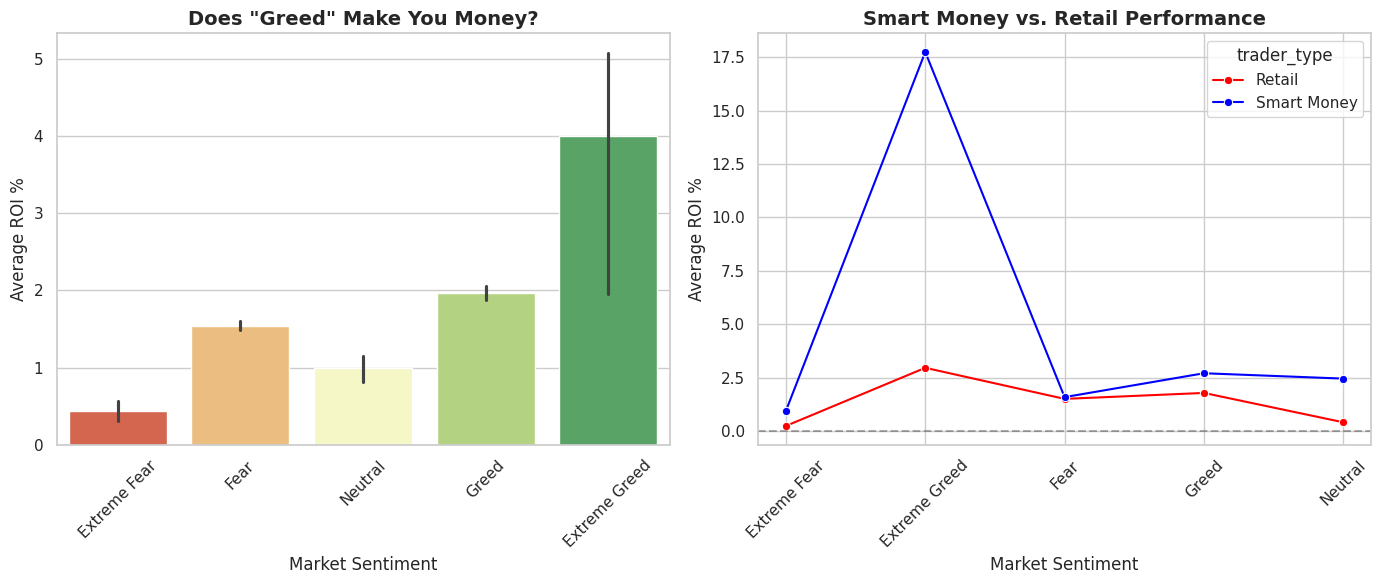

In [40]:
plt.figure(figsize=(14, 6))

# CHART 1: ROI by Sentiment
plt.subplot(1, 2, 1)
sns.barplot(x='classification', y='roi_pct', data=df, order=order, palette='RdYlGn')
plt.title('Does "Greed" Make You Money?', fontsize=14, fontweight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Average ROI %')
plt.xticks(rotation=45)

# CHART 2: Smart Money vs Retail
plt.subplot(1, 2, 2)
# We flatten the data for easy plotting
viz_data = df.groupby(['trader_type', 'classification'])['roi_pct'].mean().reset_index()
sns.lineplot(x='classification', y='roi_pct', hue='trader_type', data=viz_data,
             sort=False, marker='o', palette={'Smart Money': 'blue', 'Retail': 'red'})
plt.title('Smart Money vs. Retail Performance', fontsize=14, fontweight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Average ROI %')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()